Import packages

In [1]:
from utils import *
from matplotlib import pyplot as plt
import numpy as np
import torch
import valda
from valda.valuation import DataValuation
from valda.eval import data_removal
from valda.metrics import weighted_acc_drop

Initialize the parameters

In [2]:
train_total = 1000
train_start = 0
train_size = 200
dev_size = 100
test_size = 300
np.random.seed(0)
torch.manual_seed(0)

## Load Dataset
Load the MNIST dataset and split it into training and test sets.

In [3]:
X_train, y_train_clean, X_dev, y_dev, X_test, y_test = load_data(train_total, dev_size, test_size)
y_train, flip_indices = flip_labels(y_train_clean, flip_fraction=0.3)

Test the models on the poisoned data set

In [4]:
cnn_accuracy_poisoned, cnn_accuracies_poisoned = cnn_tests(X_train, y_train, X_dev, y_dev)
print('CNN accuracy on poisoned dataset: {}'.format(cnn_accuracy_poisoned))

logistic_accuracy_poisoned = logistic_test(X_train, y_train, X_dev, y_dev)
print('Logistic Regression accuracy on poisoned dataset: {}'.format(logistic_accuracy_poisoned))

Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.70
Accuracy of CNN model on cuda: 0.67
Accuracy of CNN model on cuda: 0.71
Accuracy of CNN model on cuda: 0.78
Accuracy of CNN model on cuda: 0.72
Accuracy of CNN model on cuda: 0.67
Accuracy of CNN model on cuda: 0.69
CNN accuracy on poisoned dataset: 0.7124999999999999
Accuracy of Logistic Regression model: 0.38
Logistic Regression accuracy on poisoned dataset: 0.38


Test the models on the clean data set

In [5]:
cnn_accuracy_pure, cnn_accuracies_pure = cnn_tests(X_train, y_train_clean, X_dev, y_dev)
print('CNN accuracy on clean dataset: {}'.format(cnn_accuracy_pure))

logistic_accuracy_pure = logistic_test(X_train, y_train_clean, X_dev, y_dev)
print('Logistic Regression accuracy on clean dataset: {}'.format(logistic_accuracy_pure))

Accuracy of CNN model on cuda: 0.90
Accuracy of CNN model on cuda: 0.88
Accuracy of CNN model on cuda: 0.88
Accuracy of CNN model on cuda: 0.86
Accuracy of CNN model on cuda: 0.88
Accuracy of CNN model on cuda: 0.88
Accuracy of CNN model on cuda: 0.87
Accuracy of CNN model on cuda: 0.86
CNN accuracy on clean dataset: 0.87625
Accuracy of Logistic Regression model: 0.82
Logistic Regression accuracy on clean dataset: 0.82


## Running
Divide the train set into batches and run the valuation.

In [6]:
X_train_batch = X_train[train_start:train_start + train_size]
y_train_batch = y_train[train_start:train_start + train_size]

In [8]:
# Define a DataValuation instance
dv = DataValuation(X_train_batch, y_train_batch, X_dev, y_dev)

# Run with the default setting:
# 1. Logistic regression as the classifier
# 2. Prediction accuracy as the value measurement
vals_tmc = dv.estimate(method="tmc-shapley")

100%|██████████| 500/500 [08:54<00:00,  1.07s/it]


The number of training data with label 0 is 22
Labels on the other side: [1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 500/500 [05:56<00:00,  1.40it/s]


score = 0.04
The number of training data with label 1 is 25
Labels on the other side: [0, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 500/500 [06:05<00:00,  1.37it/s]


score = 0.14
The number of training data with label 2 is 22
Labels on the other side: [0, 1, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 500/500 [05:56<00:00,  1.40it/s]


score = 0.04
The number of training data with label 3 is 17
Labels on the other side: [0, 1, 2, 4, 5, 6, 7, 8, 9]


100%|██████████| 500/500 [04:35<00:00,  1.82it/s]


score = 0.02
The number of training data with label 4 is 19
Labels on the other side: [0, 1, 2, 3, 5, 6, 7, 8, 9]


100%|██████████| 500/500 [05:04<00:00,  1.64it/s]


score = 0.08
The number of training data with label 5 is 17
Labels on the other side: [0, 1, 2, 3, 4, 6, 7, 8, 9]


100%|██████████| 500/500 [02:48<00:00,  2.97it/s]


score = 0.02
The number of training data with label 6 is 24
Labels on the other side: [0, 1, 2, 3, 4, 5, 7, 8, 9]


100%|██████████| 500/500 [05:36<00:00,  1.49it/s]


score = 0.04
The number of training data with label 7 is 18
Labels on the other side: [0, 1, 2, 3, 4, 5, 6, 8, 9]


100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


score = 0.04
The number of training data with label 8 is 16
Labels on the other side: [0, 1, 2, 3, 4, 5, 6, 7, 9]


100%|██████████| 500/500 [02:53<00:00,  2.89it/s]


score = 0.05
The number of training data with label 9 is 20
Labels on the other side: [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 500/500 [02:40<00:00,  3.11it/s]

score = 0.02


## Results
Get the indices of the data points with values < 0

In [32]:
min_indices_batch = [key for key, value in vals_tmc.items() if value <= 0]
min_indices_batch = np.array(min_indices_batch) + train_start

Append the indices to a file

In [33]:
if not os.path.exists('./data'):
    os.makedirs('./data')

file_path = f'./data/min_indices_{str(train_start).zfill(3)}_{str(train_start+train_size-1).zfill(3)}.npy'
np.save(file_path, min_indices_batch)

Get current min indices from file

In [34]:
min_indices_batch = np.load(f'./data/min_indices_{str(train_start).zfill(3)}_{str(train_start + train_size - 1).zfill(3)}.npy')

Visualize the data points with the TMC Shapley values below 0

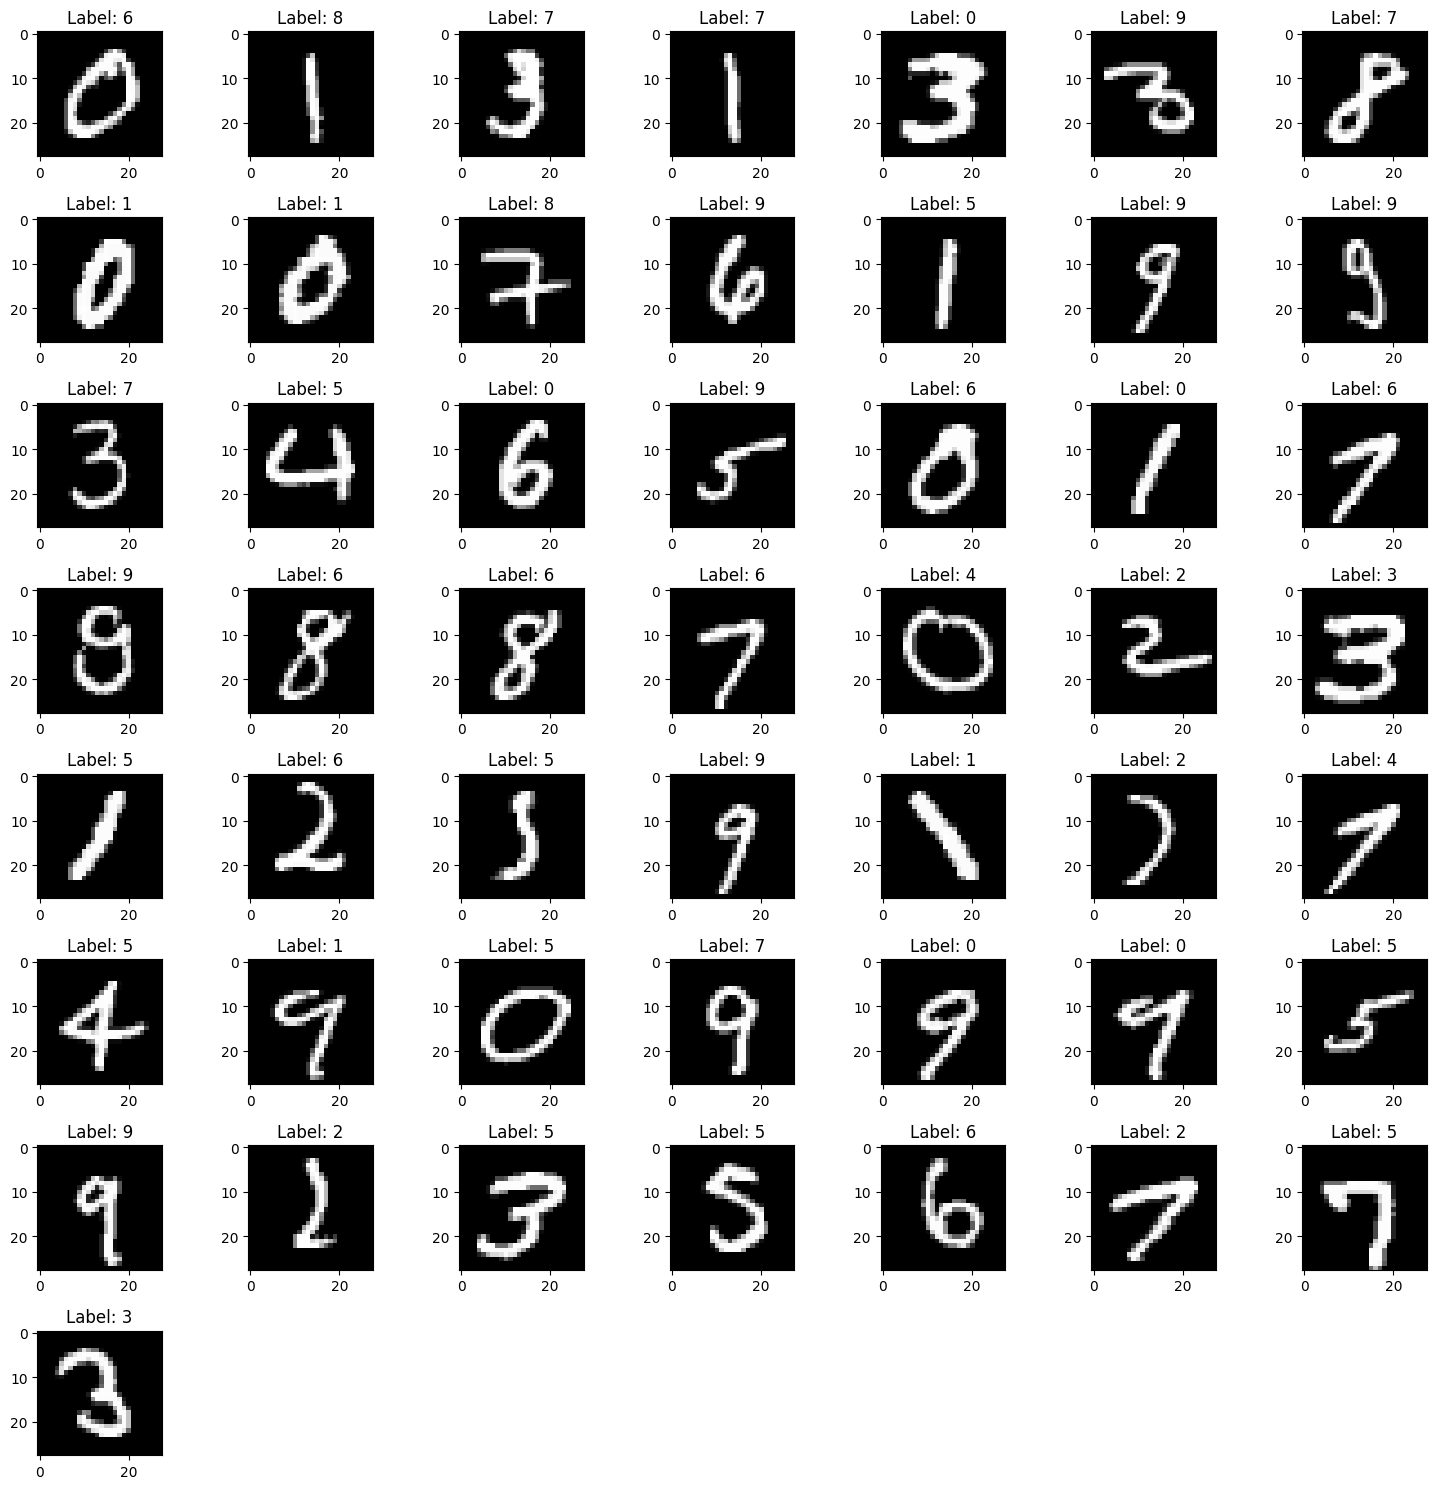

In [35]:
visualize_min_indices(X_train_batch, y_train_batch, min_indices_batch)

Merge the all indices file to the total indices file

In [36]:
min_indices = np.array([])
for train_start in range(0, train_total, train_size):
    file_path = f'./data/min_indices_{str(train_start).zfill(3)}_{str(train_start+train_size-1).zfill(3)}.npy'
    if os.path.isfile(file_path):
        old_data = np.load(file_path)
        min_indices = np.concatenate((min_indices, old_data))
min_indices = min_indices.astype(int)
np.save(f'./data/min_indices_{train_size}.npy', min_indices)

Calculate the confusion matrix

[[ 36.  14.]
 [264. 686.]]


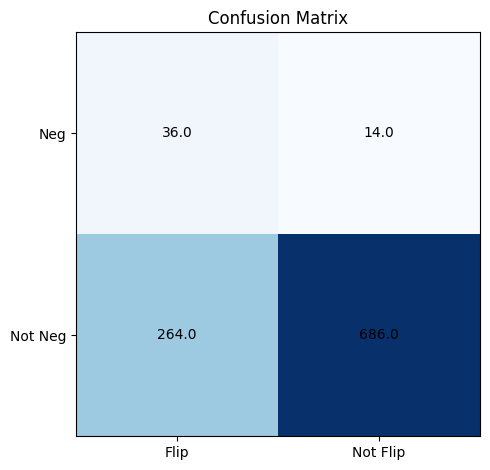

Accuracy: 0.722
Precision: 0.72
Recall: 0.12
F1 Score: 0.2057142857142857
Specificity: 0.98


In [37]:
confusion_matrix = create_confusion_matrix(min_indices, flip_indices, train_total)
print(confusion_matrix)
plot_confusion_matrix(confusion_matrix)

accuracy, precision, recall, f1_score, specificity = calculate_metrics(confusion_matrix)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Specificity: {specificity}")

Train models on the cleaned data set

In [38]:
min_indices = np.load(f'./data/min_indices_{train_size}.npy')

delete_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

cnn_accuracy = np.zeros(len(delete_ratios))
logistic_accuracy = np.zeros(len(delete_ratios))
cnn_accuracies = [None] * len(delete_ratios)

for i, delete_ratio in enumerate(delete_ratios):
    print('Delete ratio: {}'.format(delete_ratio))

    X_train_cleaned, y_train_cleaned = delete_data(X_train, y_train, min_indices, delete_ratio)

    cnn_accuracy[i], cnn_accuracies[i] = cnn_tests(X_train_cleaned, y_train_cleaned, X_test, y_test)
    logistic_accuracy[i] = logistic_test(X_train_cleaned, y_train_cleaned, X_test, y_test)

print('CNN accuracies: {}'.format(cnn_accuracy))
print('Logistic Regression accuracies: {}'.format(logistic_accuracy))

Delete ratio: 0.0
Accuracy of CNN model on cuda: 0.69
Accuracy of CNN model on cuda: 0.70
Accuracy of CNN model on cuda: 0.73
Accuracy of CNN model on cuda: 0.73
Accuracy of CNN model on cuda: 0.75
Accuracy of CNN model on cuda: 0.77
Accuracy of CNN model on cuda: 0.72
Accuracy of CNN model on cuda: 0.77
Accuracy of Logistic Regression model: 0.46
Delete ratio: 0.2
Accuracy of CNN model on cuda: 0.69
Accuracy of CNN model on cuda: 0.77
Accuracy of CNN model on cuda: 0.74
Accuracy of CNN model on cuda: 0.68
Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.74
Accuracy of CNN model on cuda: 0.77
Accuracy of CNN model on cuda: 0.79
Accuracy of Logistic Regression model: 0.49
Delete ratio: 0.4
Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.78
Accuracy of CNN model on cuda: 0.73
Accuracy of CNN model on cuda: 0.70
Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.71
Accuracy of CNN model on cuda: 0.79
Accuracy of CNN model on cuda:

C:\Users\windsnow1024\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression model: 0.50
Delete ratio: 0.6
Accuracy of CNN model on cuda: 0.78
Accuracy of CNN model on cuda: 0.71
Accuracy of CNN model on cuda: 0.73
Accuracy of CNN model on cuda: 0.71
Accuracy of CNN model on cuda: 0.79
Accuracy of CNN model on cuda: 0.80
Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.70
Accuracy of Logistic Regression model: 0.52
Delete ratio: 0.8
Accuracy of CNN model on cuda: 0.75
Accuracy of CNN model on cuda: 0.79
Accuracy of CNN model on cuda: 0.75
Accuracy of CNN model on cuda: 0.67
Accuracy of CNN model on cuda: 0.76
Accuracy of CNN model on cuda: 0.78
Accuracy of CNN model on cuda: 0.77
Accuracy of CNN model on cuda: 0.71


C:\Users\windsnow1024\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression model: 0.50
Delete ratio: 1.0
Accuracy of CNN model on cuda: 0.79
Accuracy of CNN model on cuda: 0.69
Accuracy of CNN model on cuda: 0.79
Accuracy of CNN model on cuda: 0.69
Accuracy of CNN model on cuda: 0.75
Accuracy of CNN model on cuda: 0.78
Accuracy of CNN model on cuda: 0.77
Accuracy of CNN model on cuda: 0.76
Accuracy of Logistic Regression model: 0.52
CNN accuracies: [0.73375    0.7425     0.73958333 0.74916667 0.74916667 0.7525    ]
Logistic Regression accuracies: [0.46       0.48666667 0.49666667 0.52333333 0.49666667 0.51666667]


Plot the accuracy vs delete ratio

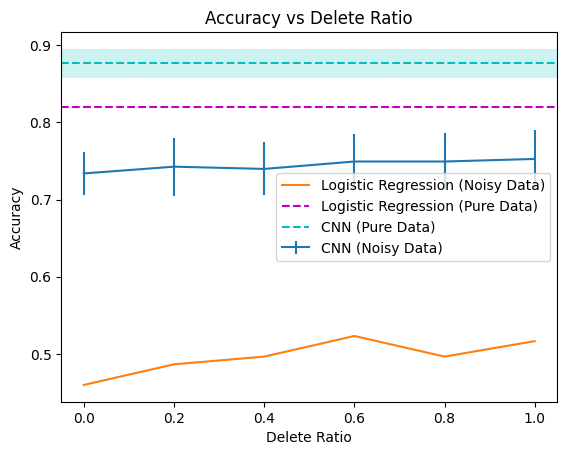

In [39]:
visualize_accuracy(delete_ratios, cnn_accuracies, logistic_accuracy, cnn_accuracies_pure, logistic_accuracy_pure)